In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 300
lr = 0.001

In [62]:

# 데이터 준비
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)


Activation: ReLU
최종 Test Accuracy: 0.8833


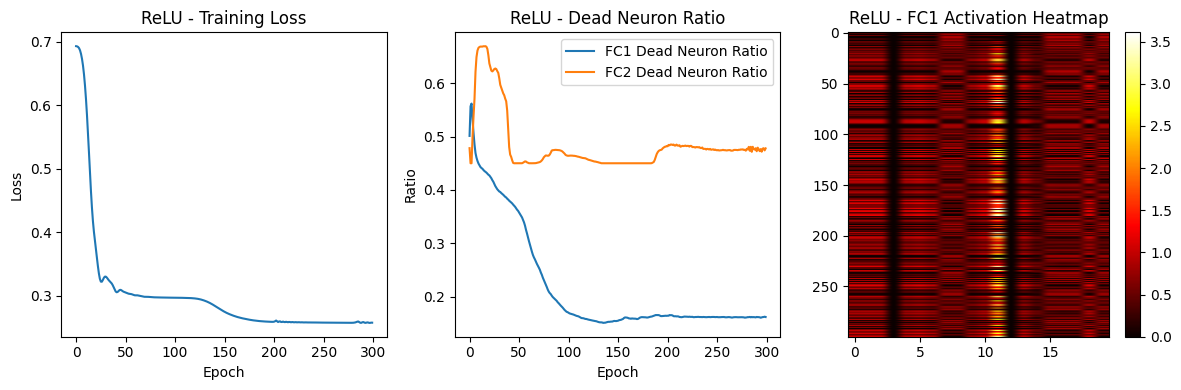

Activation: LeakyReLU
최종 Test Accuracy: 0.9700


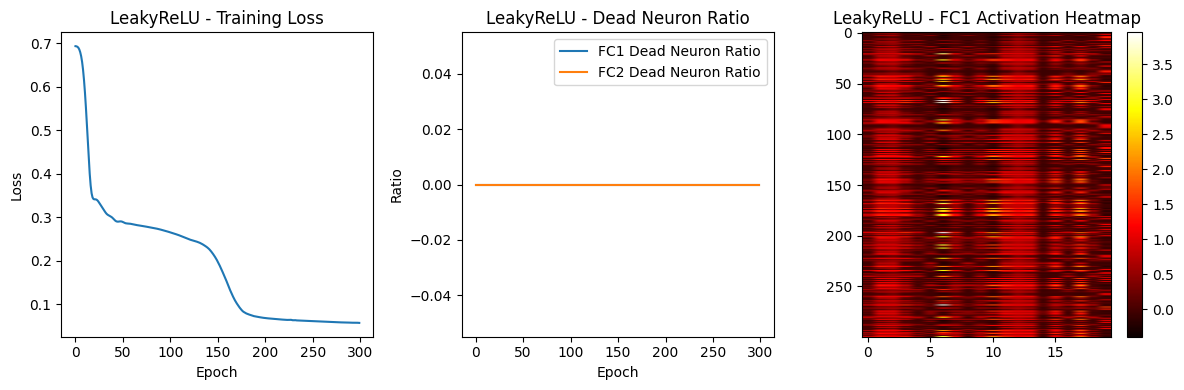

Activation: Sigmoid
최종 Test Accuracy: 0.9733


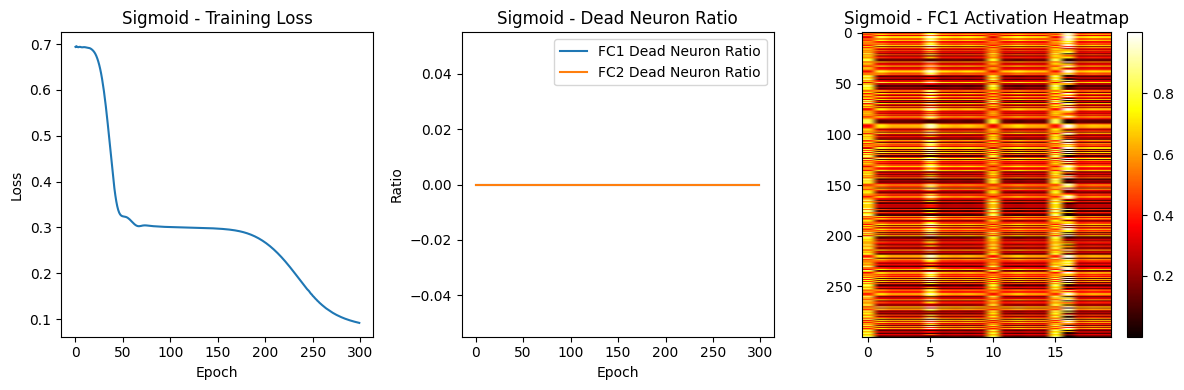

In [67]:

# 모델 정의
class SimpleNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(2, 20) #중간층에서 dead 뉴런을 확인하기 위해 은닉층 2개로 구성
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)
        self.activation = activation
        
        # Weight 초기화 (std=0.01)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        self.out1 = self.activation(self.fc1(x))
        self.out2 = self.activation(self.fc2(self.out1))
        out = self.fc3(self.out2)
        return out

# Dead neuron 비율 계산 함수
def dead_neuron_ratio(activation_output):
    # ReLU 계열에서는 출력이 0인 neuron을 dead neuron으로 간주
    dead = (activation_output == 0).float()
    ratio = dead.mean().item()
    return ratio

# 학습 및 평가 함수
def train_and_evaluate(activation, act_name):
    print(f"Activation: {act_name}")
    model = SimpleNet(activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train_losses = []
    dead_ratios_fc1 = []
    dead_ratios_fc2 = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Dead neuron 비율 측정
        model.eval()
        with torch.no_grad():
            out1 = model.out1
            out2 = model.out2
            dead_ratios_fc1.append(dead_neuron_ratio(out1))
            dead_ratios_fc2.append(dead_neuron_ratio(out2))
    
    # 최종 정확도 계산
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, preds = torch.max(test_outputs, 1)
        acc = (preds == y_test).float().mean().item()
    
    print(f"최종 Test Accuracy: {acc:.4f}")
    
    # 학습 손실 그래프
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(train_losses)
    plt.title(f'{act_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Dead neuron 비율 그래프
    plt.subplot(1,3,2)
    plt.plot(dead_ratios_fc1, label='FC1 Dead Neuron Ratio')
    plt.plot(dead_ratios_fc2, label='FC2 Dead Neuron Ratio')
    plt.title(f'{act_name} - Dead Neuron Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    
    # 히트맵 시각화 (마지막 epoch FC1 layer output)
    plt.subplot(1,3,3)
    plt.imshow(model.out1.detach().numpy(), aspect='auto', cmap='hot')
    plt.title(f'{act_name} - FC1 Activation Heatmap')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# ReLU, LeakyReLU, Sigmoid 실험 수행
train_and_evaluate(nn.ReLU(), 'ReLU')
train_and_evaluate(nn.LeakyReLU(0.07), 'LeakyReLU')
train_and_evaluate(nn.Sigmoid(), 'Sigmoid')

Epoch 1/300, Loss: 0.6501, Test Acc: 0.8000
Epoch 2/300, Loss: 0.4234, Test Acc: 0.8233
Epoch 3/300, Loss: 0.3429, Test Acc: 0.8333
Epoch 4/300, Loss: 0.3064, Test Acc: 0.8467
Epoch 5/300, Loss: 0.2856, Test Acc: 0.8667
Epoch 6/300, Loss: 0.2755, Test Acc: 0.8700
Epoch 7/300, Loss: 0.2689, Test Acc: 0.8733
Epoch 8/300, Loss: 0.2630, Test Acc: 0.8767
Epoch 9/300, Loss: 0.2600, Test Acc: 0.8767
Epoch 10/300, Loss: 0.2560, Test Acc: 0.8767
Epoch 11/300, Loss: 0.2553, Test Acc: 0.8800
Epoch 12/300, Loss: 0.2513, Test Acc: 0.8767
Epoch 13/300, Loss: 0.2488, Test Acc: 0.8800
Epoch 14/300, Loss: 0.2472, Test Acc: 0.8833
Epoch 15/300, Loss: 0.2452, Test Acc: 0.8833
Epoch 16/300, Loss: 0.2434, Test Acc: 0.8900
Epoch 17/300, Loss: 0.2427, Test Acc: 0.8800
Epoch 18/300, Loss: 0.2417, Test Acc: 0.8900
Epoch 19/300, Loss: 0.2395, Test Acc: 0.8867
Epoch 20/300, Loss: 0.2385, Test Acc: 0.8833
Epoch 21/300, Loss: 0.2376, Test Acc: 0.8867
Epoch 22/300, Loss: 0.2368, Test Acc: 0.8867
Epoch 23/300, Loss:

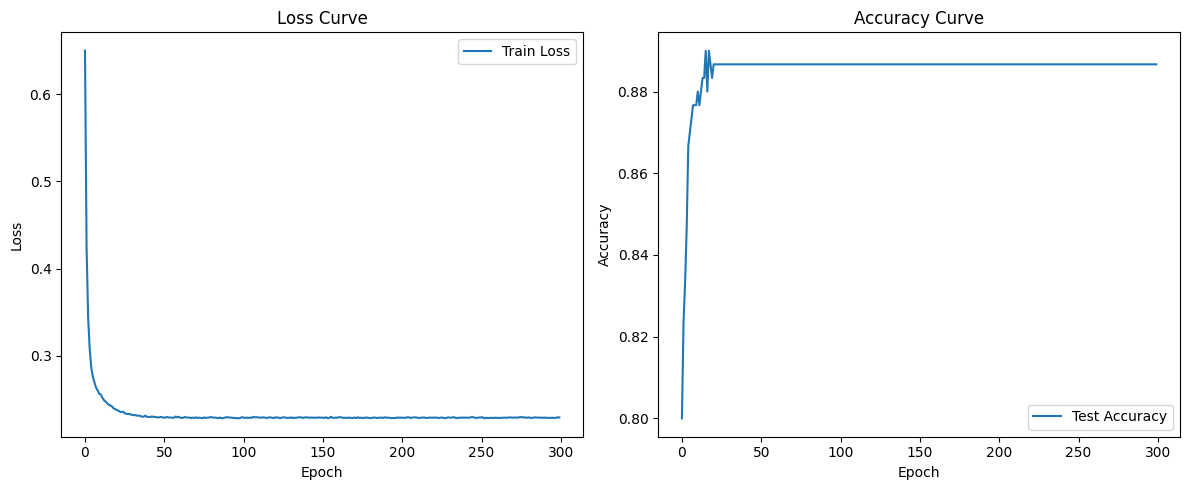

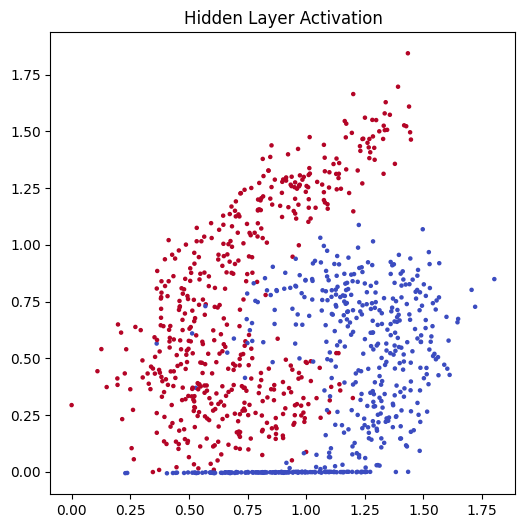

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------- [1] 실험 설정 ----------------------------
# 실험 종류 선택: 'A', 'B', 'C'
experiment = 'B'

# 손실 함수 설정: 'cross_entropy' or 'mse'
loss_type = 'cross_entropy'  # 실험 A용

# 활성화 함수 설정: 'relu', 'leaky_relu', 'sigmoid'
activation_type = 'leaky_relu'     # 실험 B용

# 옵티마이저 설정: 'sgd', 'momentum', 'adam'
optimizer_type = 'momentum'      # 실험 C용

# 학습률 설정
learning_rate = 0.001 if optimizer_type == 'adam' else 0.01
num_epochs = 300  # 기본 에폭수

# ---------------------------- [2] 데이터셋 로드 ----------------------------
def load_data(experiment):
    if experiment == 'A' or experiment == 'C':
        transform = transforms.ToTensor()
        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
        num_classes = 10
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
        test_loader = DataLoader(testset, batch_size=64, shuffle=False)
    elif experiment == 'B':
        X, y = make_moons(n_samples=1000, noise=0.2)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.long)), batch_size=64, shuffle=True)
        test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                               torch.tensor(y_test, dtype=torch.long)), batch_size=64, shuffle=False)
        input_size = 2
        num_classes = 2
    return train_loader, test_loader, input_size, num_classes

train_loader, test_loader, input_size, num_classes = load_data(experiment)

# ---------------------------- [3] 모델 정의 ----------------------------
def get_activation_fn(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()

class MLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_type):
        super(MLP, self).__init__()
        act_fn = get_activation_fn(activation_type)
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            act_fn,
            nn.Linear(256, 128),
            act_fn,
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_size, num_classes, activation_type)

# ---------------------------- [4] 손실 함수 및 옵티마이저 설정 ----------------------------
if loss_type == 'cross_entropy':
    loss_fn = nn.CrossEntropyLoss()
elif loss_type == 'mse':
    loss_fn = nn.MSELoss()

if optimizer_type == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'momentum':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_type == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# ---------------------------- [5] 학습 루프 ----------------------------
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(x_batch.size(0), -1) if experiment != 'B' else x_batch
        outputs = model(x_batch)
        
        if loss_type == 'mse':
            y_onehot = torch.zeros_like(outputs)
            y_onehot.scatter_(1, y_batch.unsqueeze(1), 1)
            loss = loss_fn(torch.softmax(outputs, dim=1), y_onehot)
        else:
            loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    train_losses.append(total_loss / len(train_loader))

    # 검증 정확도 측정
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.size(0), -1) if experiment != 'B' else x_batch
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    acc = correct / total
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Acc: {acc:.4f}")

# ---------------------------- [6] 시각화 ----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------- [7] 추가 분석 (실험 B) ----------------------------
if experiment == 'B':
    # 레이어 출력 시각화 (중간층 출력)
    def visualize_hidden_layer(model, X):
        with torch.no_grad():
            x = torch.tensor(X, dtype=torch.float32)
            hidden_output = model.net[0](x)
            hidden_output = get_activation_fn(activation_type)(hidden_output)
            hidden_output = hidden_output.numpy()
            plt.figure(figsize=(6,6))
            plt.scatter(hidden_output[:, 0], hidden_output[:, 1], c=y, cmap='coolwarm', s=5)
            plt.title("Hidden Layer Activation")
            plt.show()

    X, y = make_moons(n_samples=1000, noise=0.2)
    visualize_hidden_layer(model, X)
